In [259]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

In [260]:
rl_cf = pd.read_csv("rlplot_ar-hw_era5.txt", comment = "#", sep = " +", engine = "python", skiprows = 20, nrows = 145, 
                    header = None, names = ["n", "gumbel", "Y", "fit", "rp", "date"])
rl_f = pd.read_csv("rlplot_ar-hw_era5.txt", comment = "#", sep = " +", engine = "python", skiprows = 165, 
                    header = None, names = ["n", "gumbel", "Y", "fit", "rp", "date"])

# x-axis is on log scale, so convert return periods
transf = np.log
rl_cf["logrp"] = transf(rl_cf.rp)
rl_f["logrp"] = transf(rl_f.rp)

(28.0, 44.0)

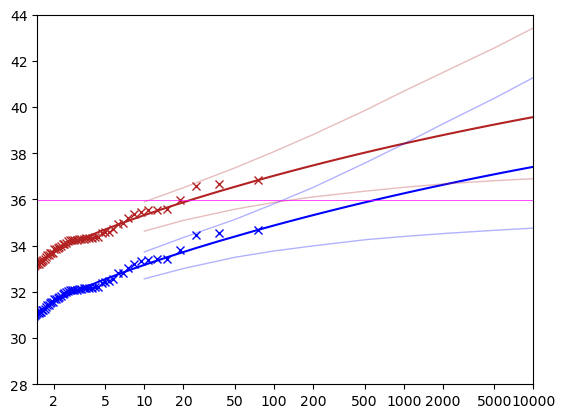

In [261]:
# plot fitted return level curves
plt.plot(rl_cf.loc[rl_cf.n != 0, "logrp"], rl_cf.loc[rl_cf.n != 0, "fit"], color = "blue")
plt.plot(rl_f.loc[rl_f.n != 0, "logrp"], rl_f.loc[rl_f.n != 0, "fit"], color = "firebrick")

# confidence bounds
plt.plot(rl_cf.loc[rl_cf.n == 0, "logrp"][:10], rl_cf.loc[rl_cf.n == 0, "fit"][:10], color = "blue", alpha = 0.3, lw = 1)
plt.plot(rl_cf.loc[rl_cf.n == 0, "logrp"][10:], rl_cf.loc[rl_cf.n == 0, "fit"][10:], color = "blue", alpha = 0.3, lw = 1)

plt.plot(rl_f.loc[(rl_f.n == 0) & (rl_f.date == 0), "logrp"][:10], rl_f.loc[(rl_f.n == 0) & (rl_f.date == 0), "fit"][:10], color = "firebrick", alpha = 0.3, lw = 1)
plt.plot(rl_f.loc[(rl_f.n == 0) & (rl_f.date == 0), "logrp"][10:], rl_f.loc[(rl_f.n == 0) & (rl_f.date == 0), "fit"][10:], color = "firebrick", alpha = 0.3, lw = 1)

# add observations
plt.plot(rl_cf.loc[rl_cf.date != 0, "logrp"], rl_cf.loc[rl_cf.date != 0, "Y"], ls = "", marker = "x", color = "blue")
plt.plot(rl_f.loc[(rl_f.date != 0) & (rl_f.n != 0), "logrp"], rl_f.loc[(rl_f.date != 0) & (rl_f.n != 0), "Y"], ls = "", marker = "x", color = "firebrick")

# line for observed event
plt.plot(rl_f.loc[(rl_f.date != 0) & (rl_f.n == 0), "logrp"], rl_f.loc[(rl_f.date != 0) & (rl_f.n == 0), "fit"], color = "magenta", lw = 0.5)

# fix axes & labels
xticks = [2,5,10,20,50,100,200,500,1000,2000,5000,10000]
plt.xticks(ticks = transf(xticks), labels = xticks)

plt.xlim(transf(1.5),transf(1e4))
plt.ylim(28,44)

### **Split data into sections**



In [263]:
# Observations

obs = pd.read_csv("AR-PY_tasmax-7day_ERA5.dat", comment = "#", sep = " ", header = None, names = ["year", "obs"], index_col = "year")
obs.index = [str(y) for y in obs.index]

obs_f, obs_cf = [df.assign(year = [str(d)[:4] for d in df.date]).loc[[str(d)[-4:] == "0101" for d in df.date],:] for df in [rl_f, rl_cf]]

obs_df = pd.merge(obs,
                  pd.merge(obs_f[["year", "Y", "rp", "logrp"]], obs_cf[["year", "Y"]], left_on = "year", right_on = "year", suffixes = ("_f", "_cf")).set_index("year"),
                  left_index = True, right_index = True)[["rp", "logrp", "obs", "Y_f", "Y_cf"]]
obs_df.to_csv("rlplot_ar-hw_obs.csv")

In [264]:
# return level curves
rl_curves = pd.merge(rl_f.loc[rl_f.n != 0, ["rp", "logrp", "fit"]],
                               rl_cf.loc[rl_cf.n != 0, ["fit"]],
                               left_index = True, right_index = True, suffixes = ("_f", "_cf"))

rl_curves.to_csv("rlplot_ar-hw_curves.csv")

In [265]:
# confidence interval curves
ci_f, ci_cf = [df.loc[(df.date == 0) & (df.n == 0), ["rp", "fit"]] for df in [rl_f, rl_cf]]

confint = reduce(lambda left, right: pd.merge(left, right, left_on = "rp", right_on = "rp", how = 'outer'),
                 [ci_f[:10].rename(columns = {"fit" : "f_lower"}),
                  ci_f[10:].rename(columns = {"fit" : "f_upper"}),
                  ci_cf[:10].rename(columns = {"fit" : "cf_lower"}),
                  ci_cf[10:].rename(columns = {"fit" : "cf_upper"})])
confint["logrp"] = transf(confint.rp)
confint.to_csv("rlplot_ar-hw_confint.csv")

In [270]:
# observed value & RP tickmarks
all_text = pd.read_table("rlplot_ar-hw_era5.txt", header = None)
return_periods = all_text.loc[all_text[0].str.contains("return period event")]

event = pd.DataFrame({"event_value" : [rl_f.fit.iloc[-1]],
              "rp_f" : float(return_periods.iloc[1,0].split("</td><td>")[2].strip()),
              "rp_cf" : float(return_periods.iloc[0,0].split("</td><td>")[2].strip())})
event["logrp_f"] = transf(event.rp_f)
event["logrp_cf"] = transf(event.rp_cf)
event["xlabel"] = "Return period"
event["ylabel"] = "Temperature (degC)"

event.to_csv("rlplot_ar-hw_misc.csv", index = None)

### **Recreate plot using csv data only**

- do we need to provide markers for tickmarks, axis ranges etc?
- do we need to provide log-transformed return periods for x axis, or is it easier to use RP & plot on log axis?

In [267]:
obs = pd.read_csv("rlplot_ar-hw_obs.csv", index_col = 0)
rl_curves = pd.read_csv("rlplot_ar-hw_curves.csv", index_col = 0)
confint = pd.read_csv("rlplot_ar-hw_confint.csv", index_col = 0)
event = pd.read_csv("rlplot_ar-hw_misc.csv")

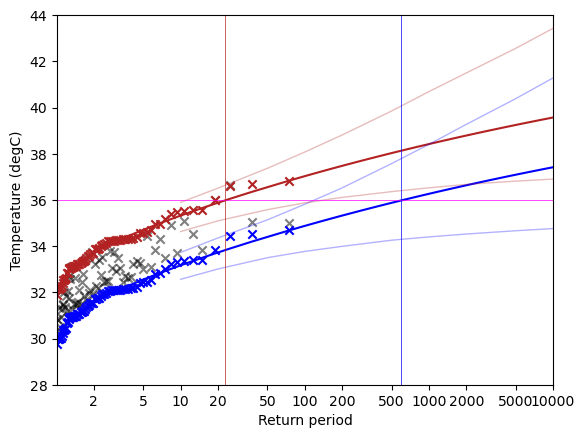

In [269]:
# plot observations & effective return levels in current & counterfactual climates
plt.scatter(obs.logrp, obs.obs, color = "k", marker = "x", alpha = 0.5)         # actual observed values & equivalent return periods

plt.scatter(obs.logrp, obs.Y_f, color = "firebrick", marker = "x")              # observed return periods vs effective return period in current climate
plt.scatter(obs.logrp, obs.Y_cf, color = "blue", marker = "x")                  # observed return periods vs effective return period in cooler climate

# add return level curves in current & counterfactual climates
plt.plot(rl_curves.logrp, rl_curves.fit_f, color = "firebrick")
plt.plot(rl_curves.logrp, rl_curves.fit_cf, color = "blue")

# plot confidence intervals
plt.plot(confint.logrp, confint.cf_lower, color = "blue", alpha = 0.3, lw = 1)
plt.plot(confint.logrp, confint.cf_upper, color = "blue", alpha = 0.3, lw = 1)

plt.plot(confint.logrp, confint.f_lower, color = "firebrick", alpha = 0.3, lw = 1)
plt.plot(confint.logrp, confint.f_upper, color = "firebrick", alpha = 0.3, lw = 1)

# add observed event
plt.axhline(event.event_value[0], color = "magenta", lw = 0.5)

# vertical lines / ticks showing the effective return period of the observed event in the present & cooler climate
plt.axvline(event.logrp_f[0], color = "firebrick", lw = 0.5)
plt.axvline(event.logrp_cf[0], color = "blue", lw = 0.5)

# fix axis labels
plt.xlabel(event.xlabel[0])
plt.ylabel(event.ylabel[0])

# fix tickmarks & axis limits 
xticks = [2,5,10,20,50,100,200,500,1000,2000,5000,10000]               # possibly hard-coded - should WWA define the axis limits, or will Tom do that? (largely aesthetic choice)
plt.xticks(ticks = np.log(xticks), labels = xticks)

plt.xlim(np.log(1.01), np.log(1e4))
plt.ylim(28,44)

plt.savefig("rlplot-example_ar-hw.png")